## More Grainsize distribution and Pandas

This notebook follows from the grainsize1 notebook. It elaborates on the method to plot 2 sample grainsize distributions on the same plot, which allows for comparison. After that, a new plot is created using every row (sample) in the dataframe.

The first step is the same as before:


### Metadata

The data were collected after the 1992 eruption to learn more about eruption source parameters (ESPs). The data file consissts of 21 columns these are:

1. Sample ID - this simply a number corresponding to a specific sample location. In some cases more than one sample is collected at a specific location, so the sample ID is repeated in the data set. One location has one sample ID.

2. Layer - The 1992 eruption occurred in 2 phases and these two phases deposited 2 layers which can be distinguished in some stratigraphic sections. The layers are "a" and "b". Layer a is stratigraphically below layer b. The first phase of the eruption deposited layer a, then there was a pause, followed by a second eruption that deposited layer b. In some sections the layers are not distinguished. For example, far from the volcano it is difficult to know if a layer is a or b. These layers are designated layer "m", for mixed. But they are probably not actually mixed, they are just not distinguished. Think of M as a combined measurement.

3. easting - this is the UTM easting location of the Sample ID location (m)

4. northing - this is the UTM northing of the Sample ID location (m)

5. total(kg/m2) - this is the mass loading in kg/m2 dry deposit observed at each Sample ID location and for each layer (a,b, of m). Mass loading can be converted to thickness since the deposit density is 1000 kg/m3

6-21. This is the mass loading by grainsize, from phi class equal to or coarser than $-4 \phi$ (coarse particles) to fine particles $>3 \phi$, seived in $1/2 \phi$ increments. If one adds the phi size mass loadings together, one should get the total (column 5). This can be used as a check on the data quality.

So the column headers are specific parameters, the rows are analyses associated with each sample location. The index goes from zero to the total number of observations. Sample ID is not used as an index because often two samples are collected at each location.

In [1]:
import pandas as pd


In [2]:
#Read in the dataframe
#specific the row
#print the row data

cn = pd.read_csv('./cerro_negro.dat')

#change the index to chose the grainsize distribution
# for a different sample
my_index = 0

#print the data for this sample
cn.loc[[my_index]]


,sample,layer,easting,northing,total(kg/m2),<=-4phi,<=-3.5phi,<=-3phi,<=-2.5phi,<=-2phi,...,<=-1phi,<=-0.5phi,<=0phi,<=0.5phi,<=1phi,<=1.5phi,<=2phi,<=2.5phi,<=3phi,>3phi
0,1,a,526774,1381087,324.22,1.21,3.45,12.69,49.02,39.56,...,64.53,39.58,23.64,13.24,1.62,0.31,0.07,0.02,0.0,0.0


### Step 2

For the selected row, calculate the median, $M_{\phi}$ and the sorting

Now, instead of "brute forcing" the code, the calculation of Inman parameters is in a function. This helps generalize the code.

In [3]:
# this function is an interpolation method
# find the point less than the inman threshold (e.g., median)
# find the point greater than teh inman threshold
#interpolate to find the inman parameter (e.g., median)
def interpolate_inman(phi, cum_mass_frac, inman_param, index):
    y1 = phi[index]
    yo = phi[index+1]
    x1 = cum_mass_frac[index]
    xo = cum_mass_frac[index+1]
    x = inman_param #median
    y = (y1-yo)/(x1-xo) * (x-xo) + yo
    return y


def inman_params(cn, my_index):
    #this function returns the median and the sorting of the grainsize distribution
    #cn is the pandas dataframe as described earlier, 
    #my_index is the index of the row for the sample id and layer of interest
   
    #it is assumed the grainsize data starts at minphi
    #and goes to max phi in 0.5 phi increments
    #change the ranges if this is not true!
    
    #minphi is the coarsest grainsize class
    #num_phi is the number of grainsize classes
    minphi = -4
    num_classes = 16
    
    #inman parameter thresholds
    inman_med = 0.5  #median
    inman_low = 0.16 #16th percentile
    inman_hi = 0.84  #84th percentile

    #extract the grainsize data for my_index
    #part of one row of the dataframe
    #the grainsize data are in columns 5 to 21
    sample1 = cn.iloc[my_index:my_index+1, 5:21]
    series = sample1.squeeze()
    
    gs = series.tolist() #list of grainsizes for the sample

    #for these grainsize data, calculate
    #cumulative mass fraction as a function
    # of graisize class
    phi =[]
    cum_mass_frac = []

    ct = minphi #smallest phi size in this dataset
    cumulative_mass = 0

    #initialize variables for inman calculation
    min_low_index = 0
    min_hi_index = 0
    min_median_index = 0
    my_phi84 = 0
    my_phi16 =0
    my_median = 0
    my_total_mass = sum(gs)
    for x in range (0,num_classes): #goes from -4 phi to >3 phi in 1/2 phi increment
        ct=minphi + x/2 #1/2 phi seive increments
        phi.append(ct)
        
        cumulative_mass = cumulative_mass+gs[x]/my_total_mass
        cum_mass_frac.append(cumulative_mass)
    
        if (cumulative_mass < inman_med):
            min_median_index = x
        
        if (cumulative_mass < inman_low):
            min_low_index = x
        
        if (cumulative_mass < inman_hi):
            min_hi_index = x

    my_median = interpolate_inman(phi, 
                              cum_mass_frac, 
                              inman_med, 
                              min_median_index)

    #the gs analysis cuts off without
    #getting enough fraction of the fines

    if (min_hi_index == len(phi)-1) or (min_low_index == 0):
        print("cannot calculate sorting")
        my_sorting = "out of range"
    else:
        my_phi84 = interpolate_inman(phi, cum_mass_frac, inman_hi, min_hi_index)
        my_phi16 = interpolate_inman(phi,cum_mass_frac, inman_low, min_low_index)
        my_sorting = my_phi84-my_phi16

    return my_median, my_sorting, cum_mass_frac, phi

### Step 3

call the functions to calculate two grainsize distributions for two different layers at the same location. Notice that the "b" layer is finer grained than the "a" layer

In [4]:
the_first_median, the_first_sorting, the_first_cdf, the_first_phi = inman_params(cn, my_index)

first_sample_id = cn.iloc[my_index]["sample"]
first_sample_layer = cn.iloc[my_index]['layer']
print("Sample ID: ", first_sample_id, "Layer: ", first_sample_layer)
print ("Median: ",the_first_median)
print("Sorting: ",the_first_sorting)

print ("\n")

the_second_median, the_second_sorting, the_second_cdf, the_second_phi = inman_params(cn, my_index+1)

second_sample_id = cn.iloc[my_index+1]["sample"]
second_sample_layer = cn.iloc[my_index+1]['layer']
print("Sample ID: ", second_sample_id, "Layer: ", second_sample_layer)
print ("Median: ",the_second_median)
print("Sorting: ",the_second_sorting)


Sample ID:  1 Layer:   a
Median:  -1.6268597236981934
Sorting:  1.9839347110387335


Sample ID:  1 Layer:   b
Median:  -0.7646434160518669
Sorting:  1.8726323786473036


### Step 4: 
Plot the two grainsize distributiosn for two different layers at the same sample location

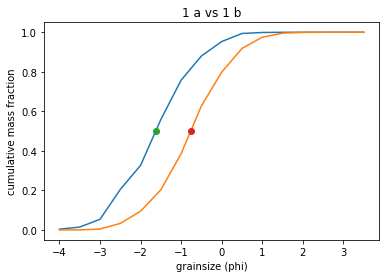

In [5]:
import matplotlib.pyplot as plt

plt.plot(the_first_phi, the_first_cdf)
plt.plot(the_second_phi, the_second_cdf)

plt.plot(the_first_median, 0.5, "o")
plt.plot(the_second_median, 0.5, "o")
plt.xlabel ("grainsize (phi)")
plt.ylabel("cumulative mass fraction")
mytitle = str(first_sample_id) + str(first_sample_layer) + " vs " + str(second_sample_id) + str(second_sample_layer)
plt.title(mytitle)
plt.show()



### Step 5
Now get fancy. Plot the median grainsize as a function of distance from the volcanic vent. Color code by "a", "b", and "m"

For all layers, the median grainsize decreases with distance from the volcanc vent, pretty noisy, probably because some samples are on the major axis of dispersion,and some are not.

In [6]:
vent_utm_east = 532350
vent_utm_north = 1382700

a_from_vent=[]
a_median = []
b_from_vent=[]
b_median = []
m_from_vent=[]
m_median = []
for x in range(len(cn.index)):
    sample_easting = cn.iloc[x]["easting"]
    sample_northing = cn.iloc[x]["northing"]
    from_vent = ((vent_utm_east - sample_easting)**2 + (vent_utm_north - sample_northing)**2)**0.5
    
    the_median, the_sorting, the_cdf, the_phi = inman_params(cn, x) 
    if (cn.iloc[x]["layer"] == " a"):
        a_from_vent.append(from_vent)
        a_median.append(the_median)
    elif (cn.iloc[x]["layer"] == " b"):
        b_from_vent.append(from_vent)
        b_median.append(the_median)
    else:
        m_from_vent.append(from_vent)
        m_median.append(the_median)

cannot calculate sorting
cannot calculate sorting


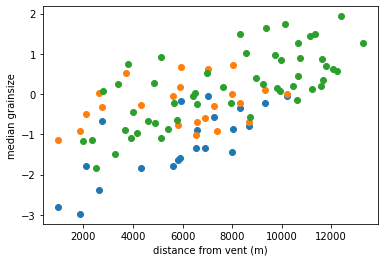

In [7]:
plt.plot(a_from_vent, a_median, "o")
plt.plot(b_from_vent, b_median, "o")
plt.plot(m_from_vent, m_median, "o")


plt.xlabel ("distance from vent (m)")
plt.ylabel("median grainsize")

plt.show()

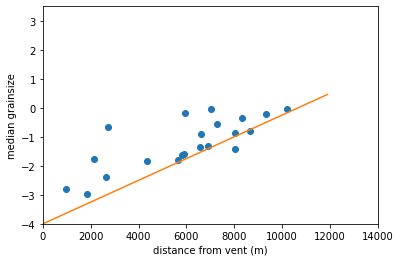

In [8]:
import numpy as np
model_from_vent = np.arange(0,12000,100)

model_median = 0.75/2000*model_from_vent -4


plt.plot(a_from_vent, a_median, "o")
plt.plot(model_from_vent, model_median)

plt.xlabel ("distance from vent (m)")
plt.ylabel("median grainsize")
plt.xlim(0,14000)
plt.ylim(-4,3.5)
plt.show()

In [9]:
#how far from the vent is the median grainsize 10 phi (clay, 1 micron)?
phi10_dist = 2000/0.75*(10+4)
print("distance at which median grainsize is 10 phi = ", phi10_dist, "m")

distance at which median grainsize is 10 phi =  37333.33333333333 m


In [10]:
from scipy import stats
print(stats.linregress(a_from_vent, a_median))


LinregressResult(slope=0.00025355974843205384, intercept=-2.7219839773700882, rvalue=0.762621901125377, pvalue=5.8326937439740306e-05, stderr=4.9339431729226055e-05, intercept_stderr=0.31918962320379146)


I guess the linear change in median grainsize with distance from the volcano indicates there is a strong (not bent over) plume for layer "a". It would be interesting to calculate the model with tephra2 and plot the theoretical change in median phi with distance from the volcano. i think it will be linear with a constant wind field - not sure

Layer b shows almost not variation in median grainsize with distance from the volcano - must be a bent over plume